In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import matplotlib.style as style
style.use('seaborn-whitegrid')

import os
import re
# import googlemaps
# import time
import pickle
from collections import defaultdict

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, TreebankWordTokenizer, wordpunct_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.util import ngrams
from nltk.corpus import stopwords

from textblob import TextBlob

import string



In [3]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [4]:
# Set pandas options
pd.set_option('max_rows', 10)
# pd.set_option('max_colwidth', -1)
# pd.set_option('display.width', 150)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

*Load the relevant data file*

In [5]:
# df = pd.read_csv('data/cleaned_reviews.csv')
# df = pd.read_csv('data/listing_descriptions.csv', index_col=0)
# df = pd.read_csv('data/cleaned_df.csv', index_col='Unnamed: 0')
# df2 = pd.read_csv('data/df_with_lda.csv', index_col='Unnamed: 0')
df3 = pd.read_csv('final_full_df.csv', index_col='Unnamed: 0')

/Users/brenner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
df3.head(2)

,id_x,host_id,host_listings_count,host_total_listings_count,neighbourhood,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,listing_id,id_y,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments,num_sentences,comment_words_only,individual_words,word_count,average_word_length,most_frequent_words,cluster_pred,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9,lda_10
0,7893,21489,1,1,Piedmont,97217,45.575479,-122.666777,House,Entire home/apt,3,1.0,2.0,2.0,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",""I...",175,1,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0.02,7893,27282,2010-02-22,52074,Shaun,Couldn't possibly had a better experience with...,couldnt possibl better experi trip would give ...,0.275000,0.650000,158,couldnt possibly better experience trip would ...,3,couldnt possibly had a better experience with ...,"['couldnt', 'possibly', 'had', 'a', 'better', ...",29,4.241379,[],3,0.272123,0.594522,0.016668,0.016668,0.016672,0.016670,0.016672,0.016669,0.016668,0.016669
1,7893,21489,1,1,Piedmont,97217,45.575479,-122.666777,House,Entire home/apt,3,1.0,2.0,2.0,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",""I...",175,1,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0.02,7893,17461247,2014-08-12,13284006,Jessica,Jesse's place was really wonderful! The apartm...,jess place realli wonder apart locat block awa...,0.275463,0.601852,670,jesses place really wonderful apartment locate...,10,jesses place was really wonderful the apartmen...,"['jesses', 'place', 'was', 'really', 'wonderfu...",119,4.436975,"[('place', 2), ('really', 2), ('apartment', 2)]",7,0.002779,0.323845,0.002779,0.002778,0.194300,0.111495,0.002779,0.002778,0.002778,0.353690


#### Using RegEx to grab individual amenities, and ultimately one-hot encode relevant ones

In [43]:
[x for x in re.findall('[^{},"]*', z) if x !='']

['TV',
 'Wifi',
 'Kitchen',
 'Free parking on premises',
 'Indoor fireplace',
 'Washer',
 'Dryer',
 'Smoke detector',
 'Fire extinguisher']

In [48]:
df['amenities'] = df['amenities'].apply(lambda z: [x for x in re.findall('[^{},"]*', z) if x !=''])

In [76]:
# Get all of the amenities into a dictionary, and sort by frequency
counts = defaultdict(int)

for i in range(5044):
    for amenity in df['amenities'][i]:
        counts[amenity] += 1

sorted(counts.items(), reverse=True, key=lambda tup: tup[1])

[('Wifi', 4971),
 ('Essentials', 4924),
 ('Heating', 4906),
 ('Smoke detector', 4848),
 ('Shampoo', 4395),
 ('Kitchen', 4368),
 ('Hangers', 4361),
 ('Carbon monoxide detector', 4350),
 ('Hair dryer', 4120),
 ('Laptop friendly workspace', 3961),
 ('Iron', 3885),
 ('Fire extinguisher', 3730),
 ('TV', 3615),
 ('Washer', 3518),
 ('Dryer', 3515),
 ('Hot water', 3434),
 ('First aid kit', 2948),
 ('Self check-in', 2909),
 ('Air conditioning', 2839),
 ('Free street parking', 2797),
 ('Family/kid friendly', 2645),
 ('Free parking on premises', 2556),
 ('Refrigerator', 2296),
 ('Dishes and silverware', 2213),
 ('Private entrance', 2103),
 ('Bed linens', 2082),
 ('Coffee maker', 2059),
 ('Microwave', 1956),
 ('Internet', 1906),
 ('Cooking basics', 1842),
 ('Stove', 1781),
 ('Extra pillows and blankets', 1770),
 ('Oven', 1706),
 ('Luggage dropoff allowed', 1596),
 ('Lock on bedroom door', 1490),
 ('Long term stays allowed', 1422),
 ('Dishwasher', 1364),
 ('Garden or backyard', 1342),
 ('Indoor fir

In [101]:
# Use regex and for loop to make syntax of one-hot encoding easier :)
for x in ['Gym', 'Kitchen', 'Pets allowed', 'Hot tub',
          'Washer', 'Refrigerator', 'Air conditioning',
          'Family/kid friendly', 'Private entrance',
          'Indoor fireplace', 'Patio or balcony',
          'Cable TV', '24-hour check-in', 'Bathtub']:
    print(f"df['amenities_{x.lower().replace(' ', '_').replace('/', '_').replace('-', '_')}'] = df['amenities'].apply(lambda x: 1 if '{x}' in set(x) else 0)")

df['amenities_gym'] = df['amenities'].apply(lambda x: 1 if 'Gym' in set(x) else 0)
df['amenities_kitchen'] = df['amenities'].apply(lambda x: 1 if 'Kitchen' in set(x) else 0)
df['amenities_pets_allowed'] = df['amenities'].apply(lambda x: 1 if 'Pets allowed' in set(x) else 0)
df['amenities_hot_tub'] = df['amenities'].apply(lambda x: 1 if 'Hot tub' in set(x) else 0)
df['amenities_washer'] = df['amenities'].apply(lambda x: 1 if 'Washer' in set(x) else 0)
df['amenities_refrigerator'] = df['amenities'].apply(lambda x: 1 if 'Refrigerator' in set(x) else 0)
df['amenities_air_conditioning'] = df['amenities'].apply(lambda x: 1 if 'Air conditioning' in set(x) else 0)
df['amenities_family_kid_friendly'] = df['amenities'].apply(lambda x: 1 if 'Family/kid friendly' in set(x) else 0)
df['amenities_private_entrance'] = df['amenities'].apply(lambda x: 1 if 'Private entrance' in set(x) else 0)
df['amenities_indoor_fireplace'] = df['amenities'].apply(lambda x: 1 if 'Indoor fireplace' in set(x) else 0)
df

In [398]:
# One hot encode all of the relevant amenities
df3['amenities_gym'] = df3['amenities'].apply(lambda x: 1 if 'Gym' in set(x) else 0)
df3['amenities_kitchen'] = df3['amenities'].apply(lambda x: 1 if 'Kitchen' in set(x) else 0)
df3['amenities_pets_allowed'] = df3['amenities'].apply(lambda x: 1 if 'Pets allowed' in set(x) else 0)
df3['amenities_hot_tub'] = df3['amenities'].apply(lambda x: 1 if 'Hot tub' in set(x) else 0)
df3['amenities_washer'] = df3['amenities'].apply(lambda x: 1 if 'Washer' in set(x) else 0)
df3['amenities_refrigerator'] = df3['amenities'].apply(lambda x: 1 if 'Refrigerator' in set(x) else 0)
df3['amenities_air_conditioning'] = df3['amenities'].apply(lambda x: 1 if 'Air conditioning' in set(x) else 0)
df3['amenities_family_kid_friendly'] = df3['amenities'].apply(lambda x: 1 if 'Family/kid friendly' in set(x) else 0)
df3['amenities_private_entrance'] = df3['amenities'].apply(lambda x: 1 if 'Private entrance' in set(x) else 0)
df3['amenities_indoor_fireplace'] = df3['amenities'].apply(lambda x: 1 if 'Indoor fireplace' in set(x) else 0)
df3['amenities_patio_or_balcony'] = df3['amenities'].apply(lambda x: 1 if 'Patio or balcony' in set(x) else 0)
df3['amenities_cable_tv'] = df3['amenities'].apply(lambda x: 1 if 'Cable TV' in set(x) else 0)
df3['amenities_24_hour_check_in'] = df3['amenities'].apply(lambda x: 1 if '24-hour check-in' in set(x) else 0)
df3['amenities_bathtub'] = df3['amenities'].apply(lambda x: 1 if 'Bathtub' in set(x) else 0)

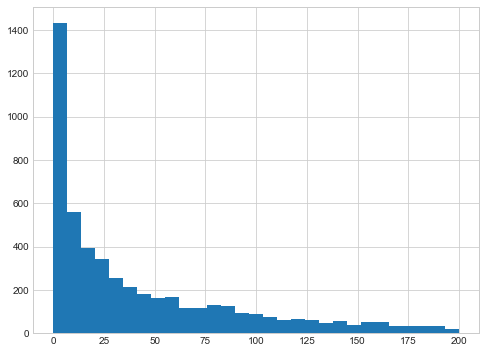

In [127]:
plt.figure(figsize=(8,6))
plt.hist(df['number_of_reviews'], bins='auto', range=(0,200), align=');

In [118]:
df['review_scores_rating'].value_counts()

100.0    1258
99.0      857
98.0      773
97.0      530
96.0      399
95.0      260
94.0      175
93.0      163
90.0      105
92.0       89
91.0       61
80.0       41
89.0       35
88.0       32
87.0       24
         ... 
83.0        8
84.0        7
81.0        6
82.0        6
73.0        5
77.0        3
70.0        3
67.0        1
40.0        1
20.0        1
78.0        1
76.0        1
68.0        1
55.0        1
79.0        1
Name: review_scores_rating, Length: 33, dtype: int64

#### Merge dataframe of listings info (df) with dataframe of reviews info (df2)

In [154]:
df3 = df.merge(df2, how='inner', left_on='id', right_on='listing_id')

In [312]:
df3.tail()

,id_x,host_id,host_listings_count,host_total_listings_count,neighbourhood,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,listing_id,id_y,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments,num_sentences,comment_words_only,individual_words,word_count,average_word_length,most_frequent_words,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9,lda_10,cluster_pred_1,cluster_pred_2,cluster_pred_3,cluster_pred_4,cluster_pred_5,cluster_pred_6,cluster_pred_7
318257,28812036,217086646,1,1,South Portland,97239,45.498897,-122.680050,Condominium,Entire home/apt,5,1.5,2.0,3.0,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",""P...",79,1,2,90.0,10.0,7.0,10.0,10.0,10.0,9.0,1,2.0,28812036,330598649,2018-09-30,105408229,Kathleen,"Moda Center. As a new host to air bnb, Doug wa...",moda center host doug quick commun recept sugg...,0.183838,0.448906,206,moda center host doug quick communication rece...,3,moda center as a new host to air bnb doug was ...,"['moda', 'center', 'as', 'a', 'new', 'host', '...",41,3.902439,"[('quick', 2), ('place', 2)]",0.012507,0.012509,0.206340,0.012500,0.012508,0.693623,0.012509,0.012501,0.012501,0.012502,0,0,0,0,0,1,0
318258,28812036,217086646,1,1,South Portland,97239,45.498897,-122.680050,Condominium,Entire home/apt,5,1.5,2.0,3.0,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",""P...",79,1,2,90.0,10.0,7.0,10.0,10.0,10.0,9.0,1,2.0,28812036,333799631,2018-10-07,217078455,Jorge,Feel at home in this cozy apartment with a gre...,feel home cozi apart great view,0.300000,0.750000,54,feel home cozy apartment great view,1,feel at home in this cozy apartment with a gre...,"['feel', 'at', 'home', 'in', 'this', 'cozy', '...",11,3.909091,[],0.016669,0.388173,0.016671,0.016668,0.478445,0.016675,0.016675,0.016672,0.016676,0.016676,1,0,0,0,0,0,0
318259,28866190,217508696,1,1,South Portland,97219,45.473536,-122.679010,Guest suite,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",""Free parking on p...",69,1,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1.0,28866190,330516667,2018-09-30,34245803,Harshit,We had a great experience. The house has all t...,great experi hous amen requir clean everyth li...,0.478889,0.733333,176,great experience house amenities required clea...,5,we had a great experience the house has all th...,"['we', 'had', 'a', 'great', 'experience', 'the...",31,4.516129,[],0.539725,0.009092,0.009091,0.009091,0.009092,0.009092,0.009091,0.387541,0.009092,0.009092,0,0,0,0,0,0,0
318260,28993289,186186834,3,3,Lents,97266,45.477691,-122.568251,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",He...",150,4,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1.0,28993289,333748311,2018-10-07,164222226,Dennis,Thank you for hosting and I appreciate the goo...,thank host appreci good commun highli recommend,0.517500,0.570000,83,thank hosting appreciate good communication hi...,2,thank you for hosting and i appreciate the goo...,"['thank', 'you', 'for', 'hosting', 'and', 'i',...",13,5.230769,[],0.014291,0.014292,0.014286,0.014287,0.014292,0.437785,0.014287,0.447906,0.014287,0.014287,0,0,0,0,0,1,0
318261,29051346,99130184,1,1,Mt. Tabor,97215,45.508009,-122.603037,Guest suite,Entire home/apt,4,1.0,2.0,2.0,Real Bed,"{TV,Wifi,Kitchen,""Pets allowed"",Heating,Washer...",73,1,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1.0,29051346,334328607,2018-10-08,1846976,Jodi,Ellie's place was terrific. Everything is new ...,elli place terrif everyth comfort live room di...,0.306882,0.697263,801,ellies place terrific everything comfortable l...,12,ellies place was terrific everything is new an...,"['ellies', 'place', 'was', 'terrific', 'ever

In [385]:
# df3.to_csv('final_full_df.csv')
df3 = pd.read_csv('final_full_df.csv', index_col='Unnamed: 0')

/Users/brenner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df3.dtypes

id_x                           int64
host_id                        int64
host_listings_count            int64
host_total_listings_count      int64
neighbourhood                 object
zipcode                       object
latitude                     float64
longitude                    float64
property_type                 object
room_type                     object
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                         float64
bed_type                      object
                              ...   
individual_words              object
word_count                     int64
average_word_length          float64
most_frequent_words           object
cluster_pred                   int64
lda_1                        float64
lda_2                        float64
lda_3                        float64
lda_4                        float64
lda_5                        float64
lda_6                        float64
l

In [388]:
df3 = pd.get_dummies(df3, columns=['cluster_pred'], drop_first=False)

In [389]:
df3 = pd.get_dummies(df3, columns=['neighbourhood', 'property_type'], drop_first=False)

In [390]:
df3 = pd.get_dummies(df3, columns=['room_type'], drop_first=False)

In [391]:
df3 = pd.get_dummies(df3, columns=['bed_type'], drop_first=False)

In [392]:
df3 = df3.dropna(axis=0)

In [ ]:
df3.

In [298]:
df3.describe()

,id_x,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,listing_id,id_y,reviewer_id,polarity,subjectivity,review_length,num_sentences,word_count,average_word_length,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9,lda_10,cluster_pred_1,cluster_pred_2,cluster_pred_3,cluster_pred_4,cluster_pred_5,cluster_pred_6,cluster_pred_7
count,3.055740e+05,3.055740e+05,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,3.055740e+05,3.055740e+05,3.055740e+05,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000,305574.000000
mean,9.763483e+06,2.795592e+07,4.734644,4.734644,45.529374,-122.647990,3.164477,1.148925,1.148278,1.713457,100.388511,1.855681,169.917686,97.199755,9.935881,9.865911,9.984400,9.976379,9.842123,9.823496,0.477969,4.898857,9.763483e+06,1.711244e+08,5.462425e+07,0.423587,0.640812,294.588476,4.395325,52.845501,4.539532,0.114813,0.106284,0.096228,0.044418,0.129837,0.133989,0.084443,0.059822,0.132582,0.097583,0.133470,0.155085,0.119519,0.119830,0.104309,0.126866,0.118367
std,7.127360e+06,3.727847e+07,54.913803,54.913803,0.030653,0.040688,1.584140,0.685585,0.736991,1.080173,196.337102,1.106612,127.167931,2.519818,0.259332,0.368355,0.134728,0.165913,0.370776,0.395109,0.499515,2.657622,7.127360e+06,9.504165e+07,5.277178e+07,0.185970,0.144858,249.448278,2.817539,45.671319,0.649886,0.184744,0.173935,0.161821,0.098070,0.198075,0.205915,0.145905,0.119651,0.201407,0.167198,0.340083,0.361986,0.324399,0.324763,0.305661,0.332824,0.323043
min,7.893000e+03,2.531000e+03,0.000000,0.000000,45.434557,-122.833981,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,40.000000,2.000000,2.000000,4.000000,4.000000,4.000000,4.000000,0.000000,0.010000,7.893000e+03,2.476700e+04,1.000000e+00,-1.000000,0.000000,4.000000,1.000000,1.000000,0.044444,0.000926,0.000834,0.000827,0.000763,0.000764,0.000769,0.000788,0.000787,0.001053,0.000800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.696524e+06,3.482338e+06,1.000000,1.000000,45.507970,-122.674915,2.000000,1.000000,1.000000,1.000000,65.000000,1.000000,76.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,2.942500,3.696524e+06,8.880216e+07,1.233932e+07,0.308333,0.561044,129.000000,3.000000,22.000000,4.194444,0.006252,0.006667,0.006253,0.005264,0.005884,0.005884,0.005885,0.005558,0.007144,0.006252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.256301e+06,1.299216e+07,1.000000,1.000000,45.528147,-122.648428,2.000000,1.000000,1.000000,1.000000,85.000000,2.000000,141.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,4.620000,8.256301e+06,1.723990e+08,3.577136e+07,0.406667,0.641735,234.000000,4.000000,42.000000,4.458333,0.012503,0.012502,0.012501,0.009091,0.012505,0.014286,0.011114,0.010001,0.014289,0.012501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.555233e+07,3.644455e+07,2.000000,2.000000,45.555548,-122.624633,4.000000,1.000000,1.000000,2.000000,110.000000,2.000000,235.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,6.500000,1.555233e+07,2.544609e+08,8.252855e+07,0.520000,0.730556,385.000000,6.000000,69.000000,4.777778,0.175572,0.152891,0.129685,0.020001,

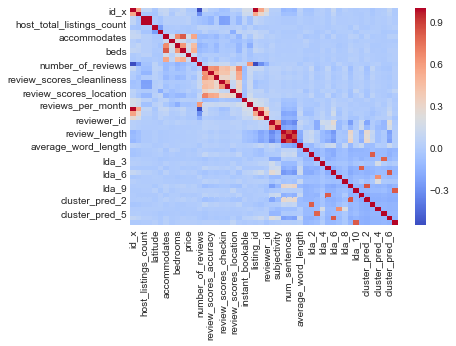

In [303]:
sns.heatmap(df3.corr(), cmap='coolwarm')

In [304]:
df3.columns

Index(['id_x', 'host_id', 'host_listings_count', 'host_total_listings_count',
       'neighbourhood', 'zipcode', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'guests_included',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'listing_id', 'id_y', 'date', 'reviewer_id', 'reviewer_name',
       'comments', 'reviews_cleaned_str', 'polarity', 'subjectivity',
       'review_length', 'cleaned_comments', 'num_sentences',
       'comment_words_only', 'individual_words', 'word_count',
       'average_word_length', 'most_frequent_words', 'lda_1', 'lda_2', 'lda_3',
       'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 'lda_10',
       'cluster_pred_1', 'cl

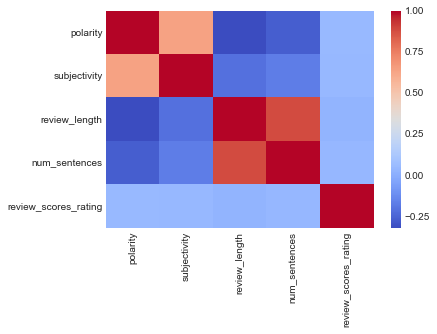

In [307]:
new = df3[['polarity', 'subjectivity',
       'review_length', 'cleaned_comments', 'num_sentences','review_scores_rating']]
sns.heatmap(new.corr(), cmap='coolwarm')

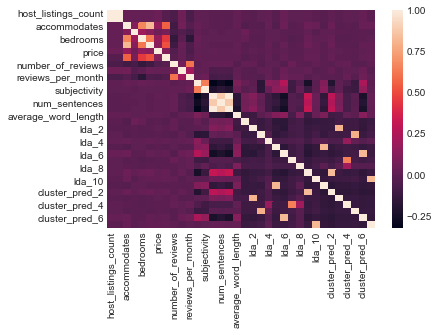

In [301]:
sns.heatmap(X.corr())

In [10]:
df3['property_type'].nunique()

29

In [ ]:
df3

In [339]:
df3.columns

Index(['id_x', 'host_id', 'host_listings_count', 'host_total_listings_count',
       'neighbourhood', 'zipcode', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'guests_included',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'listing_id', 'id_y', 'date', 'reviewer_id', 'reviewer_name',
       'comments', 'reviews_cleaned_str', 'polarity', 'subjectivity',
       'review_length', 'cleaned_comments', 'num_sentences',
       'comment_words_only', 'individual_words', 'word_count',
       'average_word_length', 'most_frequent_words', 'cluster_pred', 'lda_1',
       'lda_2', 'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9',
       'lda_10'],
    

In [64]:
X = df3[['polarity', 'subjectivity',
       'review_length', 'num_sentences', 'word_count',
       'average_word_length', 'lda_1',
       'lda_2', 'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9',
       'lda_10', 'cluster_pred_0', 'cluster_pred_1', 'cluster_pred_2', 'cluster_pred_3', 'cluster_pred_4',
       'cluster_pred_5', 'cluster_pred_6', 'cluster_pred_7']]

y = df3['price']

In [269]:
X = df3[['host_listings_count', 'host_total_listings_count',
       'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'guests_included', 'number_of_reviews', 'instant_bookable',
        'reviews_per_month', 'polarity', 'subjectivity',
       'review_length', 'num_sentences',
       'word_count',
       'average_word_length', 'lda_1', 'lda_2', 'lda_3',
       'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 'lda_10',
       'cluster_pred_1', 'cluster_pred_2', 'cluster_pred_3', 'cluster_pred_4',
       'cluster_pred_5', 'cluster_pred_6', 'cluster_pred_7']]

y = df3['price']

In [365]:
df3.dropna(inplace=True)

In [ ]:
X = df3[['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'guests_included', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'polarity', 'subjectivity',
       'review_length', 'num_sentences', 'word_count',
       'average_word_length', 'lda_1', 'lda_2',
       'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9',
       'lda_10', 'cluster_pred_0', 'cluster_pred_1', 'cluster_pred_2',
       'cluster_pred_3', 'cluster_pred_4', 'cluster_pred_5',
       'cluster_pred_6', 'cluster_pred_7', 'neighbourhood_Alameda',
       'neighbourhood_Arbor Lodge', 'neighbourhood_Argay',
       'neighbourhood_Arlington Heights', 'neighbourhood_Arnold Creek',
       'neighbourhood_Ashcreek', 'neighbourhood_Beaumont-Wilshire',
       'neighbourhood_Boise-Eliot', 'neighbourhood_Brentwood-Darlington',
       'neighbourhood_Bridgeton', 'neighbourhood_Bridlemile',
       'neighbourhood_Brooklyn', 'neighbourhood_Buckman',
       'neighbourhood_Cathedral Park', 'neighbourhood_Collins View',
       'neighbourhood_Concordia', 'neighbourhood_Creston-Kenilworth',
       'neighbourhood_Crestwood', 'neighbourhood_Cully',
       'neighbourhood_Downtown', 'neighbourhood_East Columbia',
       'neighbourhood_Eastmoreland', 'neighbourhood_Eliot',
       'neighbourhood_Far Southwest', 'neighbourhood_Forest Park',
       'neighbourhood_Foster-Powell', 'neighbourhood_Glenfair',
       'neighbourhood_Goose Hollow', 'neighbourhood_Grant Park',
       'neighbourhood_Hayden Island', 'neighbourhood_Hayhurst',
       'neighbourhood_Hazelwood', 'neighbourhood_Hillsdale',
       'neighbourhood_Hillside', 'neighbourhood_Hollywood',
       'neighbourhood_Homestead', 'neighbourhood_Hosford-Abernethy',
       'neighbourhood_Humboldt', 'neighbourhood_Irvington',
       'neighbourhood_Kenton', 'neighbourhood_Kerns',
       'neighbourhood_King', 'neighbourhood_Laurelhurst',
       'neighbourhood_Lents', 'neighbourhood_Lloyd District',
       'neighbourhood_Madison South', 'neighbourhood_Maplewood',
       'neighbourhood_Markham', 'neighbourhood_Marshall Park',
       'neighbourhood_Mill Park', 'neighbourhood_Montavilla',
       'neighbourhood_Mount Scott', 'neighbourhood_Mt. Tabor',
       'neighbourhood_Multnomah', 'neighbourhood_N. Tabor',
       'neighbourhood_Northwest District',
       'neighbourhood_Old Town/Chinatown', 'neighbourhood_Overlook',
       'neighbourhood_Parkrose', 'neighbourhood_Parkrose Heights',
       'neighbourhood_Pearl', 'neighbourhood_Piedmont',
       'neighbourhood_Pleasant Valley', 'neighbourhood_Portsmouth',
       'neighbourhood_Powellhurst-Gilbert', 'neighbourhood_Reed',
       'neighbourhood_Richmond', 'neighbourhood_Rose City Park',
       'neighbourhood_Roseway', 'neighbourhood_Russell',
       'neighbourhood_Sabin', 'neighbourhood_Sellwood-Moreland',
       'neighbourhood_South Burlingame', 'neighbourhood_South Portland',
       'neighbourhood_South Tabor', 'neighbourhood_Southwest Hills',
       'neighbourhood_St. Johns', "neighbourhood_Sullivan's Gulch",
       'neighbourhood_Sumner', 'neighbourhood_Sunderland',
       'neighbourhood_Sunnyside', 'neighbourhood_Sylvan-Highlands',
       'neighbourhood_University Park', 'neighbourhood_Vernon',
       'neighbourhood_West Portland Park', 'neighbourhood_Wilkes',
       'neighbourhood_Woodland Park', 'neighbourhood_Woodlawn',
       'neighbourhood_Woodstock', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Boat',
       'property_type_Boutique hotel', 'property_type_Bungalow',
       'property_type_Bus', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Condominium',
       'property_type_Cottage', 'property_type_Dome house',
       'property_type_Earth house', 'property_type_Farm stay',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House',
       'property_type_Houseboat', 'property_type_Hut',
       'property_type_In-law', 'property_type_Loft',
       'property_type_Other', 'property_type_Serviced apartment',
       'property_type_Tent', 'property_type_Tiny house',
       'property_type_Townhouse', 'property_type_Treehouse',
       'property_type_Villa', 'property_type_Yurt',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Airbed', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
        'amenities_gym', 'amenities_kitchen', 'amenities_pets_allowed',
       'amenities_hot_tub', 'amenities_washer', 'amenities_refrigerator',
       'amenities_air_conditioning', 'amenities_family_kid_friendly',
       'amenities_private_entrance', 'amenities_indoor_fireplace',
       'amenities_patio_or_balcony', 'amenities_cable_tv',
       'amenities_24_hour_check_in', 'amenities_bathtub']]

y=df3['price']

In [400]:
df3 = df3.sort_values('listing_id')

In [366]:
df5 = df3.sort_values(by='listing_id')

In [383]:
df3.dropna(inplace=True)

In [401]:
df3.head()

,id_x,host_id,host_listings_count,host_total_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities,price,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,listing_id,id_y,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments,num_sentences,comment_words_only,individual_words,word_count,average_word_length,most_frequent_words,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9,lda_10,cluster_pred_0,cluster_pred_1,cluster_pred_2,cluster_pred_3,cluster_pred_4,cluster_pred_5,cluster_pred_6,cluster_pred_7,neighbourhood_Alameda,neighbourhood_Arbor Lodge,neighbourhood_Argay,neighbourhood_Arlington Heights,neighbourhood_Arnold Creek,neighbourhood_Ashcreek,neighbourhood_Beaumont-Wilshire,neighbourhood_Boise-Eliot,neighbourhood_Brentwood-Darlington,neighbourhood_Bridgeton,neighbourhood_Bridlemile,neighbourhood_Brooklyn,neighbourhood_Buckman,neighbourhood_Cathedral Park,neighbourhood_Collins View,neighbourhood_Concordia,neighbourhood_Creston-Kenilworth,neighbourhood_Crestwood,neighbourhood_Cully,neighbourhood_Downtown,neighbourhood_East Columbia,neighbourhood_Eastmoreland,neighbourhood_Eliot,neighbourhood_Far Southwest,neighbourhood_Forest Park,neighbourhood_Foster-Powell,neighbourhood_Glenfair,neighbourhood_Goose Hollow,neighbourhood_Grant Park,neighbourhood_Hayden Island,neighbourhood_Hayhurst,neighbourhood_Hazelwood,neighbourhood_Hillsdale,neighbourhood_Hillside,neighbourhood_Hollywood,neighbourhood_Homestead,neighbourhood_Hosford-Abernethy,neighbourhood_Humboldt,neighbourhood_Irvington,neighbourhood_Kenton,neighbourhood_Kerns,neighbourhood_King,neighbourhood_Laurelhurst,neighbourhood_Lents,neighbourhood_Lloyd District,neighbourhood_Madison South,neighbourhood_Maplewood,neighbourhood_Markham,neighbourhood_Marshall Park,neighbourhood_Mill Park,neighbourhood_Montavilla,neighbourhood_Mount Scott,neighbourhood_Mt. Tabor,neighbourhood_Multnomah,neighbourhood_N. Tabor,neighbourhood_Northwest District,neighbourhood_Old Town/Chinatown,neighbourhood_Overlook,neighbourhood_Parkrose,neighbourhood_Parkrose Heights,neighbourhood_Pearl,neighbourhood_Piedmont,neighbourhood_Pleasant Valley,neighbourhood_Portsmouth,neighbourhood_Powellhurst-Gilbert,neighbourhood_Reed,neighbourhood_Richmond,neighbourhood_Rose City Park,neighbourhood_Roseway,neighbourhood_Russell,neighbourhood_Sabin,neighbourhood_Sellwood-Moreland,neighbourhood_South Burlingame,neighbourhood_South Portland,neighbourhood_South Tabor,neighbourhood_Southwest Hills,neighbourhood_St. Johns,neighbourhood_Sullivan's Gulch,neighbourhood_Sumner,neighbourhood_Sunderland,neighbourhood_Sunnyside,neighbourhood_Sylvan-Highlands,neighbourhood_University Park,neighbourhood_Vernon,neighbourhood_West Portland Park,neighbourhood_Wilkes,neighbourhood_Woodland Park,neighbourhood_Woodlawn,neighbourhood_Woodstock,property_type_Apartment,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Bus,property_type_Cabin,property_type_Camper/RV,property_type_Condominium,property_type_Cottage,property_type_Dome house,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Houseboat,property_type_Hut,property_type_In-law,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,amenities_gym,amenities_kitchen,amenities_pets_allowed,amenities_hot_tub,amenities_washer,amenities_refrigerator,a

In [402]:
A = df3[:200000]
B = df3[200000:]

In [403]:
A.head()

,id_x,host_id,host_listings_count,host_total_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities,price,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,listing_id,id_y,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments,num_sentences,comment_words_only,individual_words,word_count,average_word_length,most_frequent_words,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9,lda_10,cluster_pred_0,cluster_pred_1,cluster_pred_2,cluster_pred_3,cluster_pred_4,cluster_pred_5,cluster_pred_6,cluster_pred_7,neighbourhood_Alameda,neighbourhood_Arbor Lodge,neighbourhood_Argay,neighbourhood_Arlington Heights,neighbourhood_Arnold Creek,neighbourhood_Ashcreek,neighbourhood_Beaumont-Wilshire,neighbourhood_Boise-Eliot,neighbourhood_Brentwood-Darlington,neighbourhood_Bridgeton,neighbourhood_Bridlemile,neighbourhood_Brooklyn,neighbourhood_Buckman,neighbourhood_Cathedral Park,neighbourhood_Collins View,neighbourhood_Concordia,neighbourhood_Creston-Kenilworth,neighbourhood_Crestwood,neighbourhood_Cully,neighbourhood_Downtown,neighbourhood_East Columbia,neighbourhood_Eastmoreland,neighbourhood_Eliot,neighbourhood_Far Southwest,neighbourhood_Forest Park,neighbourhood_Foster-Powell,neighbourhood_Glenfair,neighbourhood_Goose Hollow,neighbourhood_Grant Park,neighbourhood_Hayden Island,neighbourhood_Hayhurst,neighbourhood_Hazelwood,neighbourhood_Hillsdale,neighbourhood_Hillside,neighbourhood_Hollywood,neighbourhood_Homestead,neighbourhood_Hosford-Abernethy,neighbourhood_Humboldt,neighbourhood_Irvington,neighbourhood_Kenton,neighbourhood_Kerns,neighbourhood_King,neighbourhood_Laurelhurst,neighbourhood_Lents,neighbourhood_Lloyd District,neighbourhood_Madison South,neighbourhood_Maplewood,neighbourhood_Markham,neighbourhood_Marshall Park,neighbourhood_Mill Park,neighbourhood_Montavilla,neighbourhood_Mount Scott,neighbourhood_Mt. Tabor,neighbourhood_Multnomah,neighbourhood_N. Tabor,neighbourhood_Northwest District,neighbourhood_Old Town/Chinatown,neighbourhood_Overlook,neighbourhood_Parkrose,neighbourhood_Parkrose Heights,neighbourhood_Pearl,neighbourhood_Piedmont,neighbourhood_Pleasant Valley,neighbourhood_Portsmouth,neighbourhood_Powellhurst-Gilbert,neighbourhood_Reed,neighbourhood_Richmond,neighbourhood_Rose City Park,neighbourhood_Roseway,neighbourhood_Russell,neighbourhood_Sabin,neighbourhood_Sellwood-Moreland,neighbourhood_South Burlingame,neighbourhood_South Portland,neighbourhood_South Tabor,neighbourhood_Southwest Hills,neighbourhood_St. Johns,neighbourhood_Sullivan's Gulch,neighbourhood_Sumner,neighbourhood_Sunderland,neighbourhood_Sunnyside,neighbourhood_Sylvan-Highlands,neighbourhood_University Park,neighbourhood_Vernon,neighbourhood_West Portland Park,neighbourhood_Wilkes,neighbourhood_Woodland Park,neighbourhood_Woodlawn,neighbourhood_Woodstock,property_type_Apartment,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Bus,property_type_Cabin,property_type_Camper/RV,property_type_Condominium,property_type_Cottage,property_type_Dome house,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Houseboat,property_type_Hut,property_type_In-law,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,amenities_gym,amenities_kitchen,amenities_pets_allowed,amenities_hot_tub,amenities_washer,amenities_refrigerator,a

In [404]:
X_train = A.loc[:, ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'guests_included', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'polarity', 'subjectivity',
       'review_length', 'num_sentences', 'word_count',
       'average_word_length', 'lda_1', 'lda_2',
       'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9',
       'lda_10', 'cluster_pred_0', 'cluster_pred_1', 'cluster_pred_2',
       'cluster_pred_3', 'cluster_pred_4', 'cluster_pred_5',
       'cluster_pred_6', 'cluster_pred_7', 'neighbourhood_Alameda',
       'neighbourhood_Arbor Lodge', 'neighbourhood_Argay',
       'neighbourhood_Arlington Heights', 'neighbourhood_Arnold Creek',
       'neighbourhood_Ashcreek', 'neighbourhood_Beaumont-Wilshire',
       'neighbourhood_Boise-Eliot', 'neighbourhood_Brentwood-Darlington',
       'neighbourhood_Bridgeton', 'neighbourhood_Bridlemile',
       'neighbourhood_Brooklyn', 'neighbourhood_Buckman',
       'neighbourhood_Cathedral Park', 'neighbourhood_Collins View',
       'neighbourhood_Concordia', 'neighbourhood_Creston-Kenilworth',
       'neighbourhood_Crestwood', 'neighbourhood_Cully',
       'neighbourhood_Downtown', 'neighbourhood_East Columbia',
       'neighbourhood_Eastmoreland', 'neighbourhood_Eliot',
       'neighbourhood_Far Southwest', 'neighbourhood_Forest Park',
       'neighbourhood_Foster-Powell', 'neighbourhood_Glenfair',
       'neighbourhood_Goose Hollow', 'neighbourhood_Grant Park',
       'neighbourhood_Hayden Island', 'neighbourhood_Hayhurst',
       'neighbourhood_Hazelwood', 'neighbourhood_Hillsdale',
       'neighbourhood_Hillside', 'neighbourhood_Hollywood',
       'neighbourhood_Homestead', 'neighbourhood_Hosford-Abernethy',
       'neighbourhood_Humboldt', 'neighbourhood_Irvington',
       'neighbourhood_Kenton', 'neighbourhood_Kerns',
       'neighbourhood_King', 'neighbourhood_Laurelhurst',
       'neighbourhood_Lents', 'neighbourhood_Lloyd District',
       'neighbourhood_Madison South', 'neighbourhood_Maplewood',
       'neighbourhood_Markham', 'neighbourhood_Marshall Park',
       'neighbourhood_Mill Park', 'neighbourhood_Montavilla',
       'neighbourhood_Mount Scott', 'neighbourhood_Mt. Tabor',
       'neighbourhood_Multnomah', 'neighbourhood_N. Tabor',
       'neighbourhood_Northwest District',
       'neighbourhood_Old Town/Chinatown', 'neighbourhood_Overlook',
       'neighbourhood_Parkrose', 'neighbourhood_Parkrose Heights',
       'neighbourhood_Pearl', 'neighbourhood_Piedmont',
       'neighbourhood_Pleasant Valley', 'neighbourhood_Portsmouth',
       'neighbourhood_Powellhurst-Gilbert', 'neighbourhood_Reed',
       'neighbourhood_Richmond', 'neighbourhood_Rose City Park',
       'neighbourhood_Roseway', 'neighbourhood_Russell',
       'neighbourhood_Sabin', 'neighbourhood_Sellwood-Moreland',
       'neighbourhood_South Burlingame', 'neighbourhood_South Portland',
       'neighbourhood_South Tabor', 'neighbourhood_Southwest Hills',
       'neighbourhood_St. Johns', "neighbourhood_Sullivan's Gulch",
       'neighbourhood_Sumner', 'neighbourhood_Sunderland',
       'neighbourhood_Sunnyside', 'neighbourhood_Sylvan-Highlands',
       'neighbourhood_University Park', 'neighbourhood_Vernon',
       'neighbourhood_West Portland Park', 'neighbourhood_Wilkes',
       'neighbourhood_Woodland Park', 'neighbourhood_Woodlawn',
       'neighbourhood_Woodstock', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Boat',
       'property_type_Boutique hotel', 'property_type_Bungalow',
       'property_type_Bus', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Condominium',
       'property_type_Cottage', 'property_type_Dome house',
       'property_type_Earth house', 'property_type_Farm stay',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House',
       'property_type_Houseboat', 'property_type_Hut',
       'property_type_In-law', 'property_type_Loft',
       'property_type_Other', 'property_type_Serviced apartment',
       'property_type_Tent', 'property_type_Tiny house',
       'property_type_Townhouse', 'property_type_Treehouse',
       'property_type_Villa', 'property_type_Yurt',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Airbed', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
        'amenities_gym', 'amenities_kitchen', 'amenities_pets_allowed',
       'amenities_hot_tub', 'amenities_washer', 'amenities_refrigerator',
       'amenities_air_conditioning', 'amenities_family_kid_friendly',
       'amenities_private_entrance', 'amenities_indoor_fireplace',
       'amenities_patio_or_balcony', 'amenities_cable_tv',
       'amenities_24_hour_check_in', 'amenities_bathtub']]

y_train = A['price']

In [405]:


X_test = B.loc[:, ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'guests_included', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'polarity', 'subjectivity',
       'review_length', 'num_sentences', 'word_count',
       'average_word_length', 'lda_1', 'lda_2',
       'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9',
       'lda_10', 'cluster_pred_0', 'cluster_pred_1', 'cluster_pred_2',
       'cluster_pred_3', 'cluster_pred_4', 'cluster_pred_5',
       'cluster_pred_6', 'cluster_pred_7', 'neighbourhood_Alameda',
       'neighbourhood_Arbor Lodge', 'neighbourhood_Argay',
       'neighbourhood_Arlington Heights', 'neighbourhood_Arnold Creek',
       'neighbourhood_Ashcreek', 'neighbourhood_Beaumont-Wilshire',
       'neighbourhood_Boise-Eliot', 'neighbourhood_Brentwood-Darlington',
       'neighbourhood_Bridgeton', 'neighbourhood_Bridlemile',
       'neighbourhood_Brooklyn', 'neighbourhood_Buckman',
       'neighbourhood_Cathedral Park', 'neighbourhood_Collins View',
       'neighbourhood_Concordia', 'neighbourhood_Creston-Kenilworth',
       'neighbourhood_Crestwood', 'neighbourhood_Cully',
       'neighbourhood_Downtown', 'neighbourhood_East Columbia',
       'neighbourhood_Eastmoreland', 'neighbourhood_Eliot',
       'neighbourhood_Far Southwest', 'neighbourhood_Forest Park',
       'neighbourhood_Foster-Powell', 'neighbourhood_Glenfair',
       'neighbourhood_Goose Hollow', 'neighbourhood_Grant Park',
       'neighbourhood_Hayden Island', 'neighbourhood_Hayhurst',
       'neighbourhood_Hazelwood', 'neighbourhood_Hillsdale',
       'neighbourhood_Hillside', 'neighbourhood_Hollywood',
       'neighbourhood_Homestead', 'neighbourhood_Hosford-Abernethy',
       'neighbourhood_Humboldt', 'neighbourhood_Irvington',
       'neighbourhood_Kenton', 'neighbourhood_Kerns',
       'neighbourhood_King', 'neighbourhood_Laurelhurst',
       'neighbourhood_Lents', 'neighbourhood_Lloyd District',
       'neighbourhood_Madison South', 'neighbourhood_Maplewood',
       'neighbourhood_Markham', 'neighbourhood_Marshall Park',
       'neighbourhood_Mill Park', 'neighbourhood_Montavilla',
       'neighbourhood_Mount Scott', 'neighbourhood_Mt. Tabor',
       'neighbourhood_Multnomah', 'neighbourhood_N. Tabor',
       'neighbourhood_Northwest District',
       'neighbourhood_Old Town/Chinatown', 'neighbourhood_Overlook',
       'neighbourhood_Parkrose', 'neighbourhood_Parkrose Heights',
       'neighbourhood_Pearl', 'neighbourhood_Piedmont',
       'neighbourhood_Pleasant Valley', 'neighbourhood_Portsmouth',
       'neighbourhood_Powellhurst-Gilbert', 'neighbourhood_Reed',
       'neighbourhood_Richmond', 'neighbourhood_Rose City Park',
       'neighbourhood_Roseway', 'neighbourhood_Russell',
       'neighbourhood_Sabin', 'neighbourhood_Sellwood-Moreland',
       'neighbourhood_South Burlingame', 'neighbourhood_South Portland',
       'neighbourhood_South Tabor', 'neighbourhood_Southwest Hills',
       'neighbourhood_St. Johns', "neighbourhood_Sullivan's Gulch",
       'neighbourhood_Sumner', 'neighbourhood_Sunderland',
       'neighbourhood_Sunnyside', 'neighbourhood_Sylvan-Highlands',
       'neighbourhood_University Park', 'neighbourhood_Vernon',
       'neighbourhood_West Portland Park', 'neighbourhood_Wilkes',
       'neighbourhood_Woodland Park', 'neighbourhood_Woodlawn',
       'neighbourhood_Woodstock', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Boat',
       'property_type_Boutique hotel', 'property_type_Bungalow',
       'property_type_Bus', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Condominium',
       'property_type_Cottage', 'property_type_Dome house',
       'property_type_Earth house', 'property_type_Farm stay',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House',
       'property_type_Houseboat', 'property_type_Hut',
       'property_type_In-law', 'property_type_Loft',
       'property_type_Other', 'property_type_Serviced apartment',
       'property_type_Tent', 'property_type_Tiny house',
       'property_type_Townhouse', 'property_type_Treehouse',
       'property_type_Villa', 'property_type_Yurt',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Airbed', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
        'amenities_gym', 'amenities_kitchen', 'amenities_pets_allowed',
       'amenities_hot_tub', 'amenities_washer', 'amenities_refrigerator',
       'amenities_air_conditioning', 'amenities_family_kid_friendly',
       'amenities_private_entrance', 'amenities_indoor_fireplace',
       'amenities_patio_or_balcony', 'amenities_cable_tv',
       'amenities_24_hour_check_in', 'amenities_bathtub']]

y_test = B['price']

In [406]:
X_train.head()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,polarity,subjectivity,review_length,num_sentences,word_count,average_word_length,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9,lda_10,cluster_pred_0,cluster_pred_1,cluster_pred_2,cluster_pred_3,cluster_pred_4,cluster_pred_5,cluster_pred_6,cluster_pred_7,neighbourhood_Alameda,neighbourhood_Arbor Lodge,neighbourhood_Argay,neighbourhood_Arlington Heights,neighbourhood_Arnold Creek,neighbourhood_Ashcreek,neighbourhood_Beaumont-Wilshire,neighbourhood_Boise-Eliot,neighbourhood_Brentwood-Darlington,neighbourhood_Bridgeton,neighbourhood_Bridlemile,neighbourhood_Brooklyn,neighbourhood_Buckman,neighbourhood_Cathedral Park,neighbourhood_Collins View,neighbourhood_Concordia,neighbourhood_Creston-Kenilworth,neighbourhood_Crestwood,neighbourhood_Cully,neighbourhood_Downtown,neighbourhood_East Columbia,neighbourhood_Eastmoreland,neighbourhood_Eliot,neighbourhood_Far Southwest,neighbourhood_Forest Park,neighbourhood_Foster-Powell,neighbourhood_Glenfair,neighbourhood_Goose Hollow,neighbourhood_Grant Park,neighbourhood_Hayden Island,neighbourhood_Hayhurst,neighbourhood_Hazelwood,neighbourhood_Hillsdale,neighbourhood_Hillside,neighbourhood_Hollywood,neighbourhood_Homestead,neighbourhood_Hosford-Abernethy,neighbourhood_Humboldt,neighbourhood_Irvington,neighbourhood_Kenton,neighbourhood_Kerns,neighbourhood_King,neighbourhood_Laurelhurst,neighbourhood_Lents,neighbourhood_Lloyd District,neighbourhood_Madison South,neighbourhood_Maplewood,neighbourhood_Markham,neighbourhood_Marshall Park,neighbourhood_Mill Park,neighbourhood_Montavilla,neighbourhood_Mount Scott,neighbourhood_Mt. Tabor,neighbourhood_Multnomah,neighbourhood_N. Tabor,neighbourhood_Northwest District,neighbourhood_Old Town/Chinatown,neighbourhood_Overlook,neighbourhood_Parkrose,neighbourhood_Parkrose Heights,neighbourhood_Pearl,neighbourhood_Piedmont,neighbourhood_Pleasant Valley,neighbourhood_Portsmouth,neighbourhood_Powellhurst-Gilbert,neighbourhood_Reed,neighbourhood_Richmond,neighbourhood_Rose City Park,neighbourhood_Roseway,neighbourhood_Russell,neighbourhood_Sabin,neighbourhood_Sellwood-Moreland,neighbourhood_South Burlingame,neighbourhood_South Portland,neighbourhood_South Tabor,neighbourhood_Southwest Hills,neighbourhood_St. Johns,neighbourhood_Sullivan's Gulch,neighbourhood_Sumner,neighbourhood_Sunderland,neighbourhood_Sunnyside,neighbourhood_Sylvan-Highlands,neighbourhood_University Park,neighbourhood_Vernon,neighbourhood_West Portland Park,neighbourhood_Wilkes,neighbourhood_Woodland Park,neighbourhood_Woodlawn,neighbourhood_Woodstock,property_type_Apartment,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Bus,property_type_Cabin,property_type_Camper/RV,property_type_Condominium,property_type_Cottage,property_type_Dome house,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Houseboat,property_type_Hut,property_type_In-law,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,amenities_gym,amenities_kitchen,amenities_pets_allowed,amenities_hot_tub,amenities_washer,amenities_refrigerator,amenities_air_conditioning,amenities_family_kid_friendly,amenities_private_entrance,amenities_indoor_fireplace,amenities_patio_or_balcony,amenities_cable_tv,amenities_24_hour_check_in,amenities_bathtub
0,45.575479,-122.666777,3,1.0,2

#### Train-test split

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=19)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
est = lr.predict(X_test)

In [41]:
print('Train R^2: ',est.score(X_train, y_train))
print('Train SSE:', 
      mean_squared_error(y_train, est.predict(X_train)))
print('Test R^2: ', est.score(X_test, y_test))
print('Test SSE:', 
      mean_squared_error(y_test, est.predict(X_test)))
print('\n')

AttributeError: 'numpy.ndarray' object has no attribute 'score'

In [ ]:
est = LinearRegression()

In [42]:
est = LinearRegression()

est.fit(X_train, y_train)
print('Train R^2: ',est.score(X_test, y_test))
print('Train SSE:', 
      mean_squared_error(y_train, est.predict(X_train)))
print('\n')

Train R^2:  0.04528524538181633
Train SSE: 6.069985057336242




In [241]:
X_train_2 = X_train['polarity']

In [276]:
est.predict(X_test).mean()

97.20041780836185

In [41]:
from sklearn import metrics

In [280]:
print(f'MAE: {metrics.mean_absolute_error(y_test, est.predict(X_test))}')
print(f'MSE: {metrics.mean_squared_error(y_test, est.predict(X_test))}')

MAE: 1.7037470389656493
MSE: 5.796081148970666


In [283]:
with open('backups/X_train.pickle', 'wb') as p:
    pickle.dump(X_train, p)
    
with open('backups/y_train.pickle', 'wb') as p:
    pickle.dump(y_train, p)
    
with open('backups/df3', 'wb') as p:
    pickle.dump(df3, p)

In [43]:
est = make_pipeline(StandardScaler(), LinearRegression())
est.fit(X_train, y_train)

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [44]:
pred = est.predict(X_test)

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [412]:
print('Train R^2: ',est.score(X_train, y_train))
print('Train SSE:', 
      mean_squared_error(y_train, est.predict(X_train)))
print('Test R^2: ', est.score(X_test, y_test))
print('Test SSE:', 
      mean_squared_error(y_test, est.predict(X_test)))
print('\n')

NameError: name 'est' is not defined

In [46]:
pred

array([97.56934545, 96.67090795, 97.11451147, ..., 97.52295873,
       97.07276342, 96.75879858])

In [47]:
y_train

174924     98.0
110176     99.0
282007     91.0
205220     99.0
73280      97.0
22379      97.0
163828     98.0
208191    100.0
188573     99.0
85316      96.0
138272     92.0
30162      95.0
190185     99.0
63215      92.0
47050      97.0
          ...  
68852      98.0
43624      98.0
288672     99.0
198674     98.0
182223     82.0
92230      97.0
143296     99.0
58655      99.0
216254     93.0
115457     98.0
125295     99.0
268936     99.0
137663     99.0
153001     99.0
127494     96.0
Name: review_scores_rating, Length: 204734, dtype: float64

In [50]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtrain,ytrain),model.score(xtest, ytest)


def quick_test_a_few_times(model, X, y, n=10):
    return (pd.DataFrame([quick_test(model, X, y) for j in range(n)],
                         columns=['Train Acc','Test Acc'])).mean()

# new_model = make_pipeline(StandardScaler(), LinearSVC(max_iter=10000))
# # pred = new_model.predict(X_test)
# # Do the test 10 times with a LinearSVC and get the average score
# print(quick_test_a_few_times(new_model, X_train, y_train))

In [55]:
def get_scores(model):
    mod = model
    mod = mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    # quick_test_a_few_times(decisiontree, X_train, y_train)

    print(f'Train accuracy: {mod.score(X_train, y_train)}')
    print(f'Test accuracy: {mod.score(X_test, y_test)}')
    print(f'Precision: {precision_score(y_test, predictions)}')
    print(f'Recall: {recall_score(y_test, predictions)}')
    print('\n')
    print(classification_report(y_test, predictions))

In [42]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.ensemble import GradientBoostingRegressor

In [58]:
get_scores(model)

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Train accuracy: 1.0
Test accuracy: -0.1368617688030913


/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [ ]:
model = make_pipeline(StandardScaler(), SVR(kernel='rbf'))
model.fit(X_train, y_train)
pred = model.predict(X_test)

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
import pprint
pprint.pprint(list_of_coeffs)

In [ ]:
list_of_coeffs = list(sorted(zip(coeffs, X.columns)))
pprint.pprint(list_of_coeffs)

In [ ]:
s2 = LinearSVC()
s2.fit(X_train, y_train)
s2.coef_ # the absolute value dictates importance

In [71]:
    predictions = model.predict(X_test)
    # quick_test_a_few_times(decisiontree, X_train, y_train)

    print(f'Train accuracy: {model.score(X_train, y_train)}')
    print(f'Test accuracy: {model.score(X_test, y_test)}')
    print('\n')

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Train accuracy: 0.13410469226577104


/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Test accuracy: 0.12584934455459584




In [ ]:
model = make_pipeline(StandardScaler(), SVR(kernel='rbf'))
model.fit(X_train, y_train)
# pred = model.predict(X_test)

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


In [410]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = make_pipeline(StandardScaler())
model.fit(X_train, y_train)
print(f'Train accuracy: {model.score(X_train, y_train)}')
print(f'Test accuracy: {model.score(X_test, y_test)}')

In [38]:
    print(f'Train accuracy: {model.score(X_train, y_train)}')
    print(f'Test accuracy: {model.score(X_test, y_test)}')

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Train accuracy: 0.09727831023431334
Test accuracy: 0.09714727252628486


/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [ ]:
model = make_pipeline(StandardScaler(), GradientBoostingRegressor())
model.fit(X_train, y_train)
print(f'Train accuracy: {model.score(X_train, y_train)}')
print(f'Test accuracy: {model.score(X_test, y_test)}')

Index(['host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'guests_included', 'number_of_reviews',
       ...
       'amenities_washer', 'amenities_refrigerator',
       'amenities_air_conditioning', 'amenities_family_kid_friendly',
       'amenities_private_entrance', 'amenities_indoor_fireplace',
       'amenities_patio_or_balcony', 'amenities_cable_tv',
       'amenities_24_hour_check_in', 'amenities_bathtub'],
      dtype='object', length=183)

(array([   80.,   522.,   270.,  3830.,  5818., 12721., 25271., 19674.,
        35074., 30621., 28137., 28030., 26899., 16171.,  8644., 14478.,
        11340.,  3217.,  7992.,  1975.,  2329.,  3437.,  1825.,  1617.,
         4292.]),
 array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,
         88.,  96., 104., 112., 120., 128., 136., 144., 152., 160., 168.,
        176., 184., 192., 200.]),
 <a list of 25 Patch objects>)

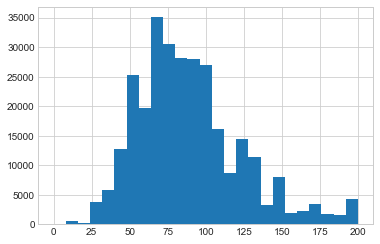

In [55]:
plt.hist(df3['price'], range=(0,200), bins=25)

(array([1.2500e+02, 3.7000e+02, 2.8300e+02, 1.5500e+02, 7.6000e+01,
        3.9400e+02, 2.6500e+02, 3.2100e+02, 7.6300e+02, 1.1850e+03,
        2.5800e+03, 3.0110e+03, 5.6780e+03, 6.5370e+03, 1.3945e+04,
        1.7967e+04, 3.1370e+04, 4.8582e+04, 6.6245e+04, 1.0553e+05]),
 array([ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
         91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.]),
 <a list of 20 Patch objects>)

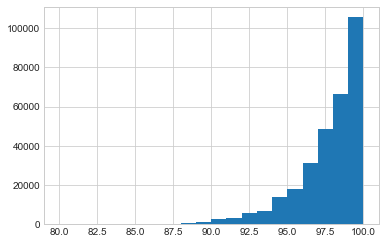

In [57]:
plt.hist(df3['review_scores_rating'], range=(80,100), bins=20)

/Users/brenner/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:720: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/brenner/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:721: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


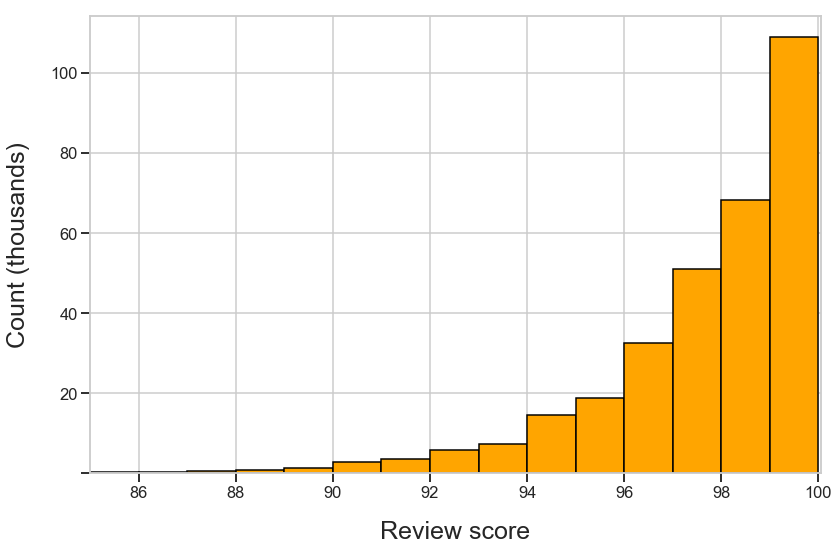

In [136]:
fig, ax = plt.subplots(figsize=(12,8))

plt.hist(df3['review_scores_rating'], range=(85,100), bins=15, color='orange', edgecolor='black')


# # plt.hist(x['price'], bins=20, color='orange', edgecolor='black')
# # sns.countplot(df3['review_scores_rating'], ax=ax, color='green', edgecolor='black')
# # ax.set_title('Ratings by Review')
ax.set_xlim(85,100.05)
# ax.set_xlabel('Nightly Rate', labelpad=30, fontsize=30)
# # ax.set_xticks(ticks=[85, 90, 95, 100])
# # ax.set_xticklabels([0, 20, 40, 60, 80, 100])
# # ax.set_xticklabels([0, .2, .4, .6, .8, 1])

# ax.tick_params(axis='both', which='major', labelsize=20)
# ax.tick_params(axis='both', which='minor', labelsize=20)

ax.set_yticklabels(['', '20', '40', '60', '80', '100'])
ax.set_xlabel('Review score', labelpad=20, fontsize=25)
ax.set_ylabel('Count (thousands)', labelpad=20, fontsize=25)
# ax.set_ylabel('Count', labelpad=20, fontsize=25)

plt.tight_layout();
# plt.savefig('plots/review_score_histogram.jpg', dpi=300)

In [137]:
!open .

In [62]:
model.steps[1][1]

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [68]:
model = make_pipeline(StandardScaler(), GradientBoostingRegressor())
model.fit(X_train, y_train)
print(f'Train accuracy: {model.score(X_train, y_train)}')
print(f'Test accuracy: {model.score(X_test, y_test)}')

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Train accuracy: 0.141286101256764


/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Test accuracy: -0.010432767001702592


In [129]:
X_train.reset_index(drop=True, inplace=True)


In [132]:
y_train.reset_index(drop=True, inplace=True)

In [135]:
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [148]:
df3.columns

Index(['id_x', 'host_id', 'host_listings_count', 'host_total_listings_count',
       'zipcode', 'latitude', 'longitude', 'accommodates', 'bathrooms',
       'bedrooms',
       ...
       'amenities_washer', 'amenities_refrigerator',
       'amenities_air_conditioning', 'amenities_family_kid_friendly',
       'amenities_private_entrance', 'amenities_indoor_fireplace',
       'amenities_patio_or_balcony', 'amenities_cable_tv',
       'amenities_24_hour_check_in', 'amenities_bathtub'],
      dtype='object', length=199)

In [163]:
df4 = df3.groupby('id_x').mean()

In [182]:
df4 = df3.groupby('listing_id').head(1)

In [177]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [207]:
pd.DataFrame(df3[df3['lda_1']==df3['lda_1'].max()]['comments']).values

array([['We really like the smell of the house. We smelled the scent of wood when we entered the house, probably cedar? And the hand soap smells very pleasant as well. The house is very clean, simple, beautiful and equipped with anything we need. It stayed warm when it was cold and raining outside. The place was beyond our expectation. Thank you for building this cozy and eco friendly house! We also liked the neighborhood and we are so amazed by the quality of food in Portland.']],
      dtype=object)

In [221]:
print("Topic #1:")
print(pd.DataFrame(df3[df3['lda_1']==df3['lda_1'].max()]['comments']).values)
print('\n')
print("Topic #2:")
print(pd.DataFrame(df3[df3['lda_2']==df3['lda_2'].max()]['comments']).values)
print('\n')
print("Topic #3:")
print(pd.DataFrame(df3[df3['lda_3']==df3['lda_3'].max()]['comments']).values)
print('\n')
print("Topic #4:")
print(pd.DataFrame(df3[df3['lda_4']==df3['lda_4'].max()]['comments']).values)
print('\n')
print("Topic #5:")
print(pd.DataFrame(df3[df3['lda_5']==df3['lda_5'].max()]['comments']).values)
print('\n')
print("Topic #6:")
print(pd.DataFrame(df3[df3['lda_6']==df3['lda_6'].max()]['comments']).values)
print('\n')
print("Topic #7:")
print(pd.DataFrame(df3[df3['lda_7']==df3['lda_7'].max()]['comments']).values)
print('\n')
print("Topic #8:")
print(pd.DataFrame(df3[df3['lda_8']==df3['lda_8'].max()]['comments']).values)
print('\n')
print("Topic #9:")
print(pd.DataFrame(df3[df3['lda_9']==df3['lda_9'].max()]['comments']).values)
print('\n')
print("Topic #10:")
print(pd.DataFrame(df3[df3['lda_10']==df3['lda_10'].max()]['comments']).values)
print('\n')

Topic #1:
[['We really like the smell of the house. We smelled the scent of wood when we entered the house, probably cedar? And the hand soap smells very pleasant as well. The house is very clean, simple, beautiful and equipped with anything we need. It stayed warm when it was cold and raining outside. The place was beyond our expectation. Thank you for building this cozy and eco friendly house! We also liked the neighborhood and we are so amazed by the quality of food in Portland.']]


Topic #2:
[["We thoroughly  enjoyed staying at Keith's place. The  private suite is very relaxing and decorated with tasteful artwork and books to read. It is surrounded by beautiful plants that form a veil of  privacy inside and out. We were able to enjoy birding right off the  attached deck. Keith made us feel welcome from the start by leaving us a bottle of wine and cheese plate to pick on as well as breakfast to start the next morning . Equally enjoyable was being able to converse with him about our

In [224]:
df3.head()

,id_x,host_id,host_listings_count,host_total_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities,price,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,listing_id,id_y,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments,num_sentences,comment_words_only,individual_words,word_count,average_word_length,most_frequent_words,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9,lda_10,cluster_pred_0,cluster_pred_1,cluster_pred_2,cluster_pred_3,cluster_pred_4,cluster_pred_5,cluster_pred_6,cluster_pred_7,neighbourhood_Alameda,neighbourhood_Arbor Lodge,neighbourhood_Argay,neighbourhood_Arlington Heights,neighbourhood_Arnold Creek,neighbourhood_Ashcreek,neighbourhood_Beaumont-Wilshire,neighbourhood_Boise-Eliot,neighbourhood_Brentwood-Darlington,neighbourhood_Bridgeton,neighbourhood_Bridlemile,neighbourhood_Brooklyn,neighbourhood_Buckman,neighbourhood_Cathedral Park,neighbourhood_Collins View,neighbourhood_Concordia,neighbourhood_Creston-Kenilworth,neighbourhood_Crestwood,neighbourhood_Cully,neighbourhood_Downtown,neighbourhood_East Columbia,neighbourhood_Eastmoreland,neighbourhood_Eliot,neighbourhood_Far Southwest,neighbourhood_Forest Park,neighbourhood_Foster-Powell,neighbourhood_Glenfair,neighbourhood_Goose Hollow,neighbourhood_Grant Park,neighbourhood_Hayden Island,neighbourhood_Hayhurst,neighbourhood_Hazelwood,neighbourhood_Hillsdale,neighbourhood_Hillside,neighbourhood_Hollywood,neighbourhood_Homestead,neighbourhood_Hosford-Abernethy,neighbourhood_Humboldt,neighbourhood_Irvington,neighbourhood_Kenton,neighbourhood_Kerns,neighbourhood_King,neighbourhood_Laurelhurst,neighbourhood_Lents,neighbourhood_Lloyd District,neighbourhood_Madison South,neighbourhood_Maplewood,neighbourhood_Markham,neighbourhood_Marshall Park,neighbourhood_Mill Park,neighbourhood_Montavilla,neighbourhood_Mount Scott,neighbourhood_Mt. Tabor,neighbourhood_Multnomah,neighbourhood_N. Tabor,neighbourhood_Northwest District,neighbourhood_Old Town/Chinatown,neighbourhood_Overlook,neighbourhood_Parkrose,neighbourhood_Parkrose Heights,neighbourhood_Pearl,neighbourhood_Piedmont,neighbourhood_Pleasant Valley,neighbourhood_Portsmouth,neighbourhood_Powellhurst-Gilbert,neighbourhood_Reed,neighbourhood_Richmond,neighbourhood_Rose City Park,neighbourhood_Roseway,neighbourhood_Russell,neighbourhood_Sabin,neighbourhood_Sellwood-Moreland,neighbourhood_South Burlingame,neighbourhood_South Portland,neighbourhood_South Tabor,neighbourhood_Southwest Hills,neighbourhood_St. Johns,neighbourhood_Sullivan's Gulch,neighbourhood_Sumner,neighbourhood_Sunderland,neighbourhood_Sunnyside,neighbourhood_Sylvan-Highlands,neighbourhood_University Park,neighbourhood_Vernon,neighbourhood_West Portland Park,neighbourhood_Wilkes,neighbourhood_Woodland Park,neighbourhood_Woodlawn,neighbourhood_Woodstock,property_type_Apartment,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Bus,property_type_Cabin,property_type_Camper/RV,property_type_Condominium,property_type_Cottage,property_type_Dome house,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Houseboat,property_type_Hut,property_type_In-law,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,amenities_gym,amenities_kitchen,amenities_pets_allowed,amenities_hot_tub,amenities_washer,amenities_refrigerator,a

In [225]:
import gensim 
from gensim.models import Word2Vec

In [283]:
df = df2[:5000]

In [254]:
model1 = gensim.models.Word2Vec(df['comment_words_only'], min_count = 1, size = 100, window = 5)

In [256]:
model1.train(df['comment_words_only'], total_examples=len(df['comment_words_only']), epochs=10)

(589417, 3511010)

In [284]:
texts = df['individual_words']

In [ ]:
text = df['individual_words']
vectorizer = CountVectorizer(ngram_range=(1,1))

vectorizer.fit(text)
x = vectorizer.transform(text)
x_back = x.toarray()

pd.DataFrame(x_back, columns=vectorizer.get_feature_names())

In [286]:
model = gensim.models.Word2Vec(texts, size=100, window=5, min_count=2, workers=4,sg=1)

In [287]:
list(model.wv.vocab.items())[:7]

[('[', <gensim.models.keyedvectors.Vocab at 0x1a26b32208>),
 ("'", <gensim.models.keyedvectors.Vocab at 0x1a2d0360f0>),
 ('c', <gensim.models.keyedvectors.Vocab at 0x1a377da2b0>),
 ('o', <gensim.models.keyedvectors.Vocab at 0x1a377da320>),
 ('u', <gensim.models.keyedvectors.Vocab at 0x1a377da358>),
 ('l', <gensim.models.keyedvectors.Vocab at 0x1a377da3c8>),
 ('d', <gensim.models.keyedvectors.Vocab at 0x1a377da2e8>)]

In [288]:
documents = df['cleaned_comments']

In [ ]:
stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in documents]

In [290]:
model = gensim.models.Word2Vec(texts, size=100, window=5, min_count=1, workers=2, sg=1)

In [291]:
print(model['trees'])

[ 0.12093134  0.05886484  0.03917719 -0.11668441  0.01337101  0.04416779
 -0.3027388   0.02895752  0.2054669   0.10149915  0.06155035 -0.10472813
  0.31965768  0.12524244 -0.18255623  0.05833543  0.04642463  0.20029815
  0.015342    0.0383232  -0.08357438  0.18495722 -0.14703643  0.02610384
  0.21822998  0.0386744   0.20629936  0.11054427  0.19344848 -0.41118076
 -0.00371632  0.39042315  0.16995071 -0.23015821  0.21777582 -0.06727105
  0.08758831 -0.48724592  0.06926239  0.21834788 -0.32524857 -0.018358
  0.20319521 -0.02418061  0.08064552 -0.1726259   0.4520521   0.03507638
 -0.19022486  0.0541723  -0.37962896  0.07004378 -0.432907    0.00640382
 -0.06715485 -0.02863289  0.2188514  -0.02482116  0.13828968 -0.15240955
 -0.12753996  0.3724413  -0.10998227 -0.18013842  0.1338349   0.01884155
  0.30563346 -0.04503935  0.10287841  0.04863508  0.09441066  0.08446525
  0.17716238 -0.09598601  0.07796517 -0.1278137  -0.17555445 -0.1267408
  0.270666   -0.1428408   0.22362712 -0.00891627  0.05

/Users/brenner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [307]:
model.most_similar('airbnb', topn=8)

/Users/brenner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('experience', 0.9010900259017944),
 ('website', 0.8992171287536621),
 ('hidden', 0.8747690916061401),
 ('experiences', 0.8691679835319519),
 ('glad', 0.8488203287124634),
 ('exceeded', 0.8466033935546875),
 ('using', 0.8452954292297363),
 ('ever', 0.8412222862243652)]

In [ ]:
model.n_similarity(]'house'], ['home'])

In [320]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318262 entries, 0 to 318261
Data columns (total 28 columns):
listing_id             318262 non-null int64
id                     318262 non-null int64
date                   318262 non-null object
reviewer_id            318262 non-null int64
reviewer_name          318262 non-null object
comments               317953 non-null object
reviews_cleaned_str    316725 non-null object
polarity               318262 non-null float64
subjectivity           318262 non-null float64
review_length          318262 non-null int64
cleaned_comments       316725 non-null object
num_sentences          318262 non-null int64
comment_words_only     317255 non-null object
individual_words       318262 non-null object
word_count             318262 non-null int64
average_word_length    318262 non-null float64
most_frequent_words    318262 non-null object
cluster_pred           318262 non-null int64
lda_1                  318262 non-null float64
lda_2             

In [32]:
import matplotlib.style as style

In [35]:
style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

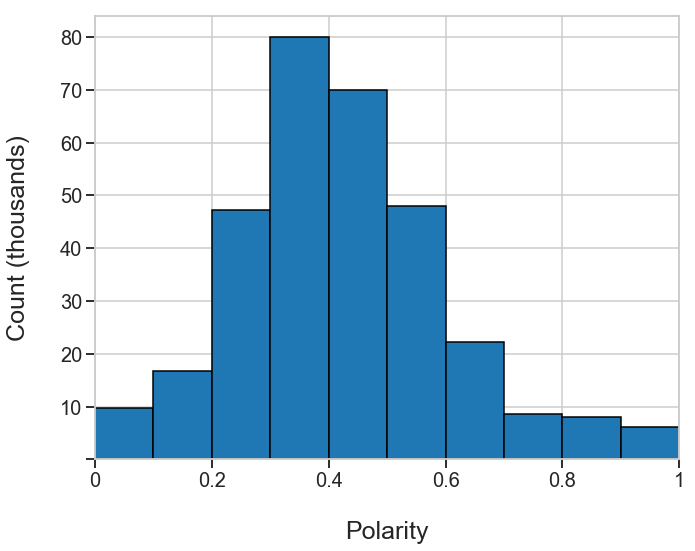

In [32]:
fig, ax = plt.subplots(figsize=(10,8))
plt.hist(df3['polarity'], bins=20, edgecolor='black', cumulative=False);
ax.set_xlim(0.0, 1.0)
ax.set_xlabel('Polarity', labelpad=30, fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

ax.set_yticklabels(['', '10', '20', '30', '40', '50', '60', '70', '80'])

ax.set_ylabel('Count (thousands)', labelpad=30, fontsize=25)
ax.set_xticklabels([0, .2, .4, .6, .8, 1])
plt.tight_layout()

# plt.savefig('plots/polarity.jpg', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
plt.hist(df3['polarity'], bins=25, edgecolor='black', cumulative=False);
ax.set_xlim(0.0, 1.0)
ax.set_xlabel('Polarity', labelpad=30, fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

ax.set_yticklabels(['', '10,000', '20,000', '30,000', '40,000', '50,000', '60,000'])

ax.set_ylabel('Count', labelpad=30, fontsize=30)
ax.set_xticklabels([0, .2, .4, .6, .8, 1])
plt.tight_layout()

# plt.savefig('plots/walk_score_and_home_price.jpg')

In [33]:
df3.head(1)

,id_x,host_id,host_listings_count,host_total_listings_count,neighbourhood,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,listing_id,id_y,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments,num_sentences,comment_words_only,individual_words,word_count,average_word_length,most_frequent_words,cluster_pred,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9,lda_10
0,7893,21489,1,1,Piedmont,97217,45.575479,-122.666777,House,Entire home/apt,3,1.0,2.0,2.0,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",""I...",175,1,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0.02,7893,27282,2010-02-22,52074,Shaun,Couldn't possibly had a better experience with...,couldnt possibl better experi trip would give ...,0.275,0.65,158,couldnt possibly better experience trip would ...,3,couldnt possibly had a better experience with ...,"['couldnt', 'possibly', 'had', 'a', 'better', ...",29,4.241379,[],3,0.272123,0.594522,0.016668,0.016668,0.016672,0.01667,0.016672,0.016669,0.016668,0.016669


In [45]:
df3['reviews_cleaned_str'] = df3['reviews_cleaned_str'].astype('str')

In [59]:
word_counts = defaultdict(int)
df3['reviews_cleaned_str'].apply(count_words)

0         None
1         None
2         None
3         None
4         None
5         None
6         None
7         None
8         None
9         None
10        None
11        None
12        None
13        None
14        None
          ... 
318247    None
318248    None
318249    None
318250    None
318251    None
318252    None
318253    None
318254    None
318255    None
318256    None
318257    None
318258    None
318259    None
318260    None
318261    None
Name: reviews_cleaned_str, Length: 318262, dtype: object

In [57]:
def count_words(x):
    for word in x.split():
        word_counts[word] +=1

In [63]:
words = sorted(word_counts.items(), key=lambda k_v: k_v[1], reverse=True)[:50]

In [67]:
words_1 = [word[0] for word in words]
frequencies = [word[1] for word in words]

In [85]:
words_1[4] = 'location'

In [107]:
words_1[10] = 'house'
words_1[17] = 'everything'
words_1[19] = 'easy'

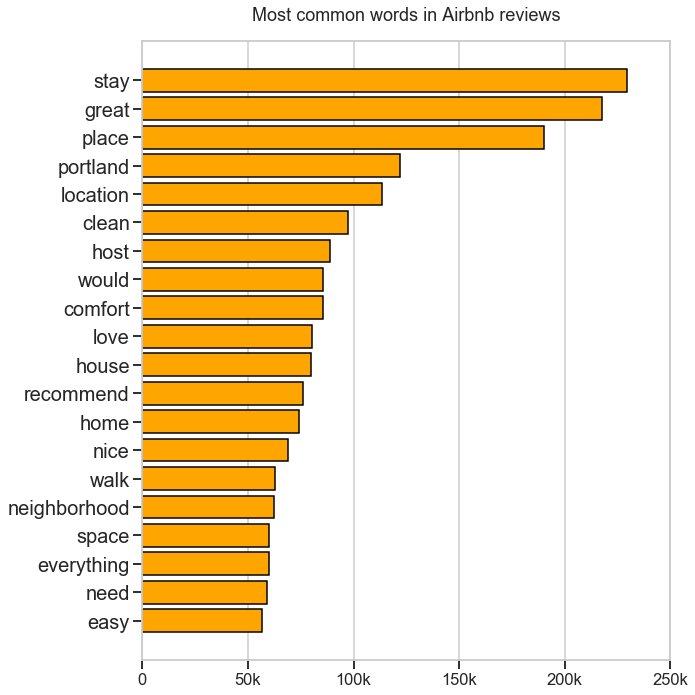

In [118]:
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(words_1[:20], frequencies[:20], color='orange', edgecolor='black')
ax.set_title('Most common words in Airbnb reviews', pad=20)
ax.invert_yaxis()
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
ax.set_xlim(0,250000)
# ax.grid(which='major', axis='x', linestyle='-')
ax.yaxis.grid(False, which='major')
# ax.set_xlabel('Count (thousands)', pad=20)

# ax.set_yticklabels(['', '10,000', '20,000', '30,000', '40,000', '50,000', '60,000'])

# ax.set_ylabel('Count', labelpad=30, fontsize=30)
ax.set_xticklabels(['0', '50k', '100k', '150k', '200k', '250k'])
plt.tight_layout()
# plt.savefig('plots/most_common_words_20.jpg', dpi=300)